# Embedding 

The aim of this notebook is to test the embedding model and see if the results look logical for the naked eye. 
What is more, few graphs with different libraries will be created to see, which one is visually most appealing and simple to use.

## Imports

In [1]:
import itertools
import re
import json

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

# embedding
from sentence_transformers import SentenceTransformer

# graphs
from bokeh.io import export_png
import networkx as nx

from bokeh.plotting import figure, from_networkx
from bokeh.transform import linear_cmap
from bokeh.models import Range1d, Circle, MultiLine
from bokeh.io import output_notebook, show, save
from bokeh.palettes import Blues8
from pyvis.network import Network

## Data Processing

As the data is divided into several files, we first need to read it in and parse the necessary columns.

### Generic Data

In [2]:
# specify the column names 
column_names = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movie_metadata_df = pd.read_table('../data/raw/movie.metadata.tsv', names=column_names)
movie_metadata_df.head(5)

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [3]:
# let's take a subset of the data for testing
movie_metadata_df.dropna(subset=['release_date', 'box_office_revenue'], inplace=True)
movie_metadata_df.release_date = movie_metadata_df.release_date.str.slice(start=0, stop=4).astype(int)
movie_metadata_df = movie_metadata_df[movie_metadata_df.release_date >= 2000]
movie_metadata_df.head(5)

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
29,156558,/m/014k4y,Baby Boy,2001,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
53,12008535,/m/02vlsqt,Rudo y Cursi,2008,11091868.0,103.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0b90_r"": ""Mexico"", ""/m/09c7w0"": ""United S...","{""/m/01z02hx"": ""Sports"", ""/m/07s9rl0"": ""Drama""..."
60,5708633,/m/0f0d1p,The Great New Wonderful,2006,172055.0,87.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/0hj3n0w"": ""Ensembl..."
119,3873713,/m/0b4f1s,Lee Dae-ro Can't Die,2005,4736013.0,108.0,"{""/m/02hwhyv"": ""Korean Language""}","{""/m/06qd3"": ""South Korea""}","{""/m/02kdv5l"": ""Action"", ""/m/01z4y"": ""Comedy""}"


In [4]:
sample_df = movie_metadata_df.sample(200)

In addition to the ID (we need Wikipedia ID for plots and Freebase ID for genres), we're interested in genres. 
As they are quite noisy, let's process them a bit.

In [6]:
def gen_list_of_genres(value: str) -> str:
    """Parse dict string and return only genres as joint string separated by '|'."""
    genre_dict = json.loads(value)
    return '|'.join(list(genre_dict.values()))

In [7]:
# let's turn the strings of dictionaries into list of strings
sample_df.genres = sample_df.genres.apply(gen_list_of_genres)

In [8]:
# let's keep the necessary columns
genre_df = sample_df[['wikipedia_id', 'freebase_id', 'name', 'genres', 'box_office_revenue']]
genre_df.head(5)

,wikipedia_id,freebase_id,name,genres,box_office_revenue
59080,23966679,/m/076xkdz,Summer Wars,Science Fiction|Japanese Movies|Adventure|Anim...,18353560.0
15512,5791363,/m/0f4rvf,Tideland,Thriller|Drama|Fantasy|Indie|Childhood Drama,566611.0
50029,1599541,/m/05fm6m,Bewitched,Romantic comedy|Romance Film|Fantasy|Comedy,131426169.0
81055,20926377,/m/02vrgnr,Hancock,Crime Fiction|Science Fiction|Superhero movie|...,624386746.0
40865,3231682,/m/0900j5,The Texas Chainsaw Massacre,Thriller|Horror|Road-Horror|Remake|Cult|Myster...,107071655.0


### Plots

As we want to embed plots, let's read them in and merge with `genre_df`.

In [9]:
plot_column_names = ['wikipedia_id', 'plot']
plot_df = pd.read_csv('../data/raw/plot_summaries.txt', sep="\t", names=plot_column_names) 
plot_df.head(5)

,wikipedia_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [10]:
# let's now merge the DataFrames
merged_df = genre_df.merge(plot_df, on='wikipedia_id', how='inner')
merged_df

,wikipedia_id,freebase_id,name,genres,box_office_revenue,plot
0,23966679,/m/076xkdz,Summer Wars,Science Fiction|Japanese Movies|Adventure|Anim...,18353560.0,Kenji Koiso is a young high school student w...
1,5791363,/m/0f4rvf,Tideland,Thriller|Drama|Fantasy|Indie|Childhood Drama,566611.0,"Tideland centers on an abandoned child, Jeliza..."
2,1599541,/m/05fm6m,Bewitched,Romantic comedy|Romance Film|Fantasy|Comedy,131426169.0,Jack Wyatt is a narcissistic actor who is app...
3,20926377,/m/02vrgnr,Hancock,Crime Fiction|Science Fiction|Superhero movie|...,624386746.0,John Hancock is an alcoholic man with super p...
4,3231682,/m/0900j5,The Texas Chainsaw Massacre,Thriller|Horror|Road-Horror|Remake|Cult|Myster...,107071655.0,"On August 18, 1973, five teenagers, Erin , her..."
...,...,...,...,...,...,...
180,481605,/m/02fqrf,Batman Begins,Crime Fiction|Thriller|Superhero movie|Crime D...,372710015.0,"As a child, Bruce Wayne falls into a well, dev..."
181,3041142,/m/08ml8v,Crying Fist,Sports|Drama,10024751.0,"Jobless, besieged by creditors, and abandoned ..."
182,1194084,/m/04g73n,Chicken Little,Science Fiction|Adventure|Computer Animation|A...,320432837.0,"In the small town of Oakey Oaks, Chicken Littl..."
183,8464511,/m/0274cf8,Breakfast with Scot,LGBT|Indie|Gay|Gay Interest|Drama|Comedy|Gay T...,46060.0,Eric McNally is a gay retired hockey player t...


## Embedding

We're using the model described in this [paper](https://arxiv.org/pdf/2212.03533.pdf), which can be downloaded [here](https://huggingface.co/intfloat/e5-large-v2). To download the model, run in the `models` directory:

```
git lfs install
git clone https://huggingface.co/intfloat/e5-large-v2
```

### Modelling

In [11]:
def get_embedding(text: str, model) -> np.ndarray:
    """
    Split texts into sentences and get embeddings for each sentence.
    The final embeddings is the mean of all sentence embeddings.
    Reference: https://towardsdatascience.com/easily-get-high-quality-embeddings-with-sentencetransformers-c61c0169864b
    
    :param text: Input text.
    :param model: update. For embedding.
    :return: Embeddings.
    """
    return np.mean(
        model.encode(
            list(set(re.findall('[^!?。.？！]+[!?。.？！]?', text)))
        ), axis=0)

In [12]:
model = SentenceTransformer('../models/e5-large-v2')

In [13]:
# create dictionary with embeddings for all the movies
input_template = 'query: {}'
embeddings = {}

for index, row in merged_df.iterrows():
    embeddings[row['name']] = model.encode(input_template.format(row['plot']), normalize_embeddings=True)

### Similarity Matrix

In [14]:
# generate all possible combinations for dot product 
movie_sample = list(embeddings.keys())
combinations = list(itertools.combinations(movie_sample, 2))

In [15]:
# generate the similarity matrix
similarity_matrix = pd.DataFrame(index=movie_sample, columns=movie_sample, dtype=float)

for (movie_1, movie_2) in combinations:
    similarity = embeddings[movie_1] @ embeddings[movie_2]
    similarity_matrix.at[movie_1, movie_2] = similarity
    similarity_matrix.at[movie_2, movie_1] = similarity

In [16]:
similarity_matrix.head(5)

,Summer Wars,Tideland,Bewitched,Hancock,The Texas Chainsaw Massacre,Journey 2: The Mysterious Island,Catch That Kid,Persepolis,The Bourne Legacy,Deck the Halls,...,The Killer Inside Me,Puccini for Beginners,Stop-Loss,Center Stage,Looney Tunes: Back in Action,Batman Begins,Crying Fist,Chicken Little,Breakfast with Scot,Samayou Yaiba
Summer Wars,NaN,0.789636,0.772265,0.795485,0.784103,0.808697,0.798881,0.798755,0.799068,0.786953,...,0.776417,0.766207,0.796594,0.779392,0.799767,0.798521,0.716801,0.789543,0.712960,0.809516
Tideland,0.789636,NaN,0.795333,0.798359,0.829437,0.791614,0.801558,0.784794,0.786925,0.832978,...,0.835904,0.776489,0.818105,0.799613,0.785605,0.777078,0.715730,0.806646,0.732860,0.793917
Bewitched,0.772265,0.795333,NaN,0.791470,0.779958,0.795333,0.788288,0.780777,0.771413,0.805539,...,0.796020,0.787598,0.778141,0.811448,0.791063,0.794021,0.706516,0.786372,0.761885,0.768529
Hancock,0.795485,0.798359,0.791470,NaN,0.785362,0.794157,0.802826,0.796751,0.783186,0.809382,...,0.808957,0.761963,0.806316,0.778956,0.810348,0.803557,0.750184,0.806700,0.729868,0.790784
The Texas Chainsaw Massacre,0.784103,0.829437,0.779958,0.785362,NaN,0.785591,0.811874,0.775653,0.803392,0.813011,...,0.840322,0.782786,0.828717,0.799721,0.793563,0.803943,0.711369,0.793221,0.731280,0.787881


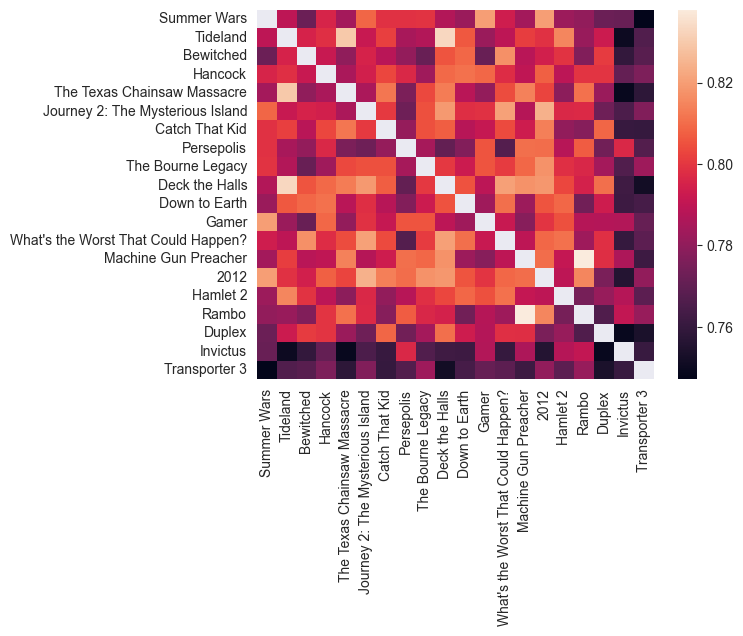

In [17]:
first_20 = similarity_matrix.columns[:20].tolist()
sample_similarity_matrix = similarity_matrix.loc[first_20, first_20]

sns.heatmap(sample_similarity_matrix)
plt.show();

<AxesSubplot:title={'center':'Distribution of similarity values'}, ylabel='Frequency'>

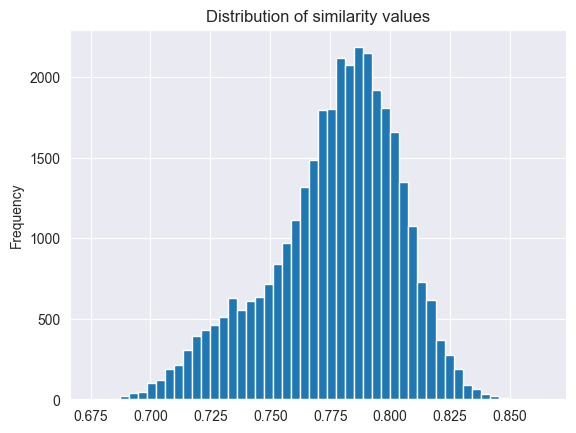

In [18]:
# let's check the distribution of similarity values
similarity_values_array = similarity_matrix.values
similarity_values = similarity_values_array[~np.isnan(similarity_values_array)]
pd.Series(similarity_values).plot.hist(bins=50, title='Distribution of similarity values')

In [19]:
pd.Series(similarity_values).describe()

count    34040.000000
mean         0.776609
std          0.027229
min          0.675934
25%          0.761221
50%          0.780646
75%          0.795929
max          0.864134
dtype: float64

## Graph Generation

Now that we have the similarities between the movies, we can set the threshold and generate a network of nodes.

### NetworkX

In [20]:
similarity_threshold = 0.794151  # let's take 75th percentile

nodes_df = pd.DataFrame(columns=['Source', 'Target', 'Weight'])

G = nx.Graph()
G.add_nodes_from(sample_df.name.tolist())
for (movie_1, movie_2) in combinations:
    similarity = similarity_matrix.at[movie_1, movie_2]
    if similarity > similarity_threshold:
        nodes_df.loc[len(nodes_df)] = [movie_1, movie_2, similarity]
        
G = nx.from_pandas_edgelist(nodes_df, 'Source', 'Target', 'Weight')

In [21]:
# add name as an attribute
names = dict((name, name) for name in G.nodes)
nx.set_node_attributes(G, name='name', values=names)

In [22]:
# calculate degree for each node
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

In [23]:
# add box office revenues
revenue = merged_df.set_index('name').box_office_revenue

box_office_revenue = dict((name, revenue.loc[name]) for name in G.nodes)
nx.set_node_attributes(G, name='box_office_revenue', values=box_office_revenue)

### Bokeh

In [30]:
# adjust the size of the nodes by normalizing the revenue
revenue_normalized =(revenue - revenue.min()) / (revenue.max() - revenue.min())

adjusted_node_size = dict((name, revenue_normalized.loc[name] * 10 + 2) for name in G.nodes)
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

In [31]:
# hacky way to rename the nodes since bokeh couldn't otherwise handle that
mapping = dict((n, i) for i, n in enumerate(G.nodes))
H = nx.relabel_nodes(G, mapping)

In [49]:
output_notebook()

# choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'degree'

color_palette = Blues8

#Choose a title!
title = 'First test with Bokeh'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Name", "@name"), ("Degree", "@degree"), ("Box Office Revenue", "@box_office_revenue")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(
    width=1000, 
    height=600,
    tooltips = HOVER_TOOLTIPS,
    tools="pan,wheel_zoom,save,reset", 
    active_scroll='wheel_zoom',
    x_range=Range1d(-10.1, 10.1), 
    y_range=Range1d(-10.1, 10.1),
    title=title
)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(H, nx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)

Loading BokehJS ...

Bokeh seems a good approach with many good features, but few limitations:
- not an easy way for saving a chart that's edited manually (e.g. zoomed in)
- documentation is quite bad
- requires many extra features and hacking even the PATH for making it work

The html versions could be good to embed to the final website.

### Pyvis

In [50]:
from pyvis.network import Network

nt = Network('800px', '1000px', notebook=True, cdn_resources='in_line')
nt.from_nx(G)
nt.show('example.html')

Pyvis tends to be quite heavy and could only be an option with smaller subsets and simpler examples.
As Plotly and Matplotlib turned out to be really unsuitable for plotting networks, it seems that 

## Summary

Based on the first graphs, it seems that the approach where we simply embed the plots doesn't generate clusters, 
but a one big hive. With "Lord of the Rings" as an only exception, most of the financially more successful movies were
situated inside the hive with high degree (lot of similar movie plots). Thus, it might make sense to try an 
alternative approach, where we let the NLI predict the probability of a class.

Another challenge lies in plotting the networks in Jupyter notebooks. As the graphs are quite complex and most packages use html as the output, 
they are not visible in e.g. GitHub. Will this be a problem or embedded html in the datastory is enough?